# analisis incial datos no textuales

In [1]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pickle
from tqdm.notebook import tqdm
import re



In [2]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')
sns.set(style='white', context='notebook', palette='deep')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

### Presidentes FOMC

In [3]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2024,1,1)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2024-01-01


In [4]:
def get_chairperson(x):
    '''
    Devuelve el nombre completo del presidente para la fecha dada x.
    '''

    # Si x es una cadena, conviértela a datetime
    if isinstance(x, str):
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d').date()
        except ValueError:
            return None  # Retorna None si la cadena no está en el formato esperado

    # Filtra los presidentes basados en la fecha dada x
    chairperson = chairpersons[(chairpersons['FromDate'] <= x) & (x <= chairpersons['ToDate'])]

    # Verifica si hay un presidente para la fecha dada
    if not chairperson.empty:
        return f"{chairperson.iloc[0]['FirstName']} {chairperson.iloc[0]['Surname']}"
    else:
        return None  # O cualquier otro valor predeterminado en caso de que no haya un presidente coincidente



### CALENDARIO

In [5]:
file = open('../data/FOMC/fomc_calendar.pickle', 'rb')

fomc_calendar = pickle.load(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(454, 4)


,date,unscheduled,forecast,confcall
0,1980-01-09,False,False,False
1,1980-02-05,False,False,False
2,1980-02-22,False,False,True
3,1980-03-07,False,False,True
4,1980-03-18,False,False,False
...,...,...,...,...
449,2024-06-12,False,True,False
450,2024-07-31,False,False,False
451,2024-09-18,False,True,False
452,2024-11-07,False,False,False


In [6]:

fomc_calendar = fomc_calendar.loc[fomc_calendar['date'] >= dt.datetime(1982, 9, 27)]

# Use date as index
fomc_calendar.set_index('date', inplace=True)
fomc_calendar.head()

,unscheduled,forecast,confcall
date,,,
1982-10-05,False,False,False
1982-11-16,False,False,False
1982-12-21,False,False,False
1983-01-14,False,False,True
1983-01-21,False,False,True


In [7]:
fomc_calendar.tail()

,unscheduled,forecast,confcall
date,,,
2024-06-12,False,True,False
2024-07-31,False,False,False
2024-09-18,False,True,False
2024-11-07,False,False,False
2024-12-18,False,True,False


### AÑADIRT PRWSINDETE AL CALENDARIO

In [8]:
fomc_calendar['ChairPerson'] = fomc_calendar.index.map(get_chairperson)
fomc_calendar

C:\Users\luisl\AppData\Local\Temp\ipykernel_30544\369244201.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fomc_calendar['ChairPerson'] = fomc_calendar.index.map(get_chairperson)


,unscheduled,forecast,confcall,ChairPerson
date,,,,
1982-10-05,False,False,False,Paul Volcker
1982-11-16,False,False,False,Paul Volcker
1982-12-21,False,False,False,Paul Volcker
1983-01-14,False,False,True,Paul Volcker
1983-01-21,False,False,True,Paul Volcker
...,...,...,...,...
2024-06-12,False,True,False,None
2024-07-31,False,False,False,None
2024-09-18,False,True,False,None


## cARGAR DATOS NO TEXTUALES MEDIANTE QUANDL

In [10]:
from fredapi import Fred
import pandas as pd

# Configura tu clave API de FRED aquí
api_key = 'a163c009fedf87834db3a0d9536205cc'
fred = Fred(api_key=api_key)

# Lista de series de FRED y sus descripciones
series = {
    'GDP': 'Gross Domestic Product',
    'GDPPOT': 'Potential Gross Domestic Product',
    'FEDFUNDS': 'Federal Funds Effective Rate',
    'PAYEMS': 'Total Nonfarm Payrolls (Employment)',
    'UNRATE': 'Unemployment Rate',
    'RSXFS': 'Retail Sales Excluding Food Services',
    'HNFSEPUSSA': 'Houses Sold: United States',
    'PCE': 'Personal Consumption Expenditures',
    'PI': 'Personal Income',
    'DFEDTAR': 'Rate',
    'DFEDTARU': 'Upper',
    'DFEDTARL': 'Lower',
    'DFF': 'Efective',
    'GDPC1': 'GDPC1',
    'PCEPILFE': 'PCEPILFE',
    'CPIAUCSL': 'CPIAUCSL',
    'RRSFS': 'RRSFS',
    'HSN1F': 'HSN1F'
    
}

# Función para obtener datos de una serie
def get_fred_data(series_id, description):
    data = fred.get_series(series_id)
    return pd.DataFrame(data, columns=[description])

# Obtener y almacenar los datos
data_frames = {}
for series_id, description in series.items():
    try:
        data_frames[description] = get_fred_data(series_id, description)
        print(f"Datos obtenidos para {description}")
    except Exception as e:
        print(f"Error al obtener datos para {description}: {e}")

Datos obtenidos para Gross Domestic Product
Datos obtenidos para Potential Gross Domestic Product
Datos obtenidos para Federal Funds Effective Rate
Datos obtenidos para Total Nonfarm Payrolls (Employment)
Datos obtenidos para Unemployment Rate
Datos obtenidos para Retail Sales Excluding Food Services
Datos obtenidos para Houses Sold: United States
Datos obtenidos para Personal Consumption Expenditures
Datos obtenidos para Personal Income
Datos obtenidos para Rate
Datos obtenidos para Upper
Datos obtenidos para Lower
Datos obtenidos para Efective
Datos obtenidos para GDPC1
Datos obtenidos para PCEPILFE
Datos obtenidos para CPIAUCSL
Datos obtenidos para RRSFS
Datos obtenidos para HSN1F


In [11]:
print(data_frames['Rate'])

             Rate
1982-09-27  10.25
1982-09-28  10.25
1982-09-29  10.25
1982-09-30  10.25
1982-10-01  10.00
...           ...
2008-12-11   1.00
2008-12-12   1.00
2008-12-13   1.00
2008-12-14   1.00
2008-12-15   1.00

[9577 rows x 1 columns]


In [12]:
fedtar = data_frames['Rate']
fedtaru = data_frames['Upper']
fedtarl = data_frames['Lower']
fedtarl = fedtarl.rename(columns={'Lower': 'Rate'})
fedrate_df = pd.concat([fedtar, fedtarl], axis=0)
fedrate_df

,Rate
1982-09-27,10.25
1982-09-28,10.25
1982-09-29,10.25
1982-09-30,10.25
1982-10-01,10.00
...,...
2024-02-07,5.25
2024-02-08,5.25
2024-02-09,5.25
2024-02-10,5.25


In [13]:

fedrate_df.index = pd.to_datetime(fedrate_df.index, format="%Y-%m-%d")
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: float(x))
# Add difference from previous value
fedrate_df['diff'] = fedrate_df['Rate'].diff()


In [14]:
fedrate_df

,Rate,diff
1982-09-27,10.25,NaN
1982-09-28,10.25,0.00
1982-09-29,10.25,0.00
1982-09-30,10.25,0.00
1982-10-01,10.00,-0.25
...,...,...
2024-02-07,5.25,0.00
2024-02-08,5.25,0.00
2024-02-09,5.25,0.00
2024-02-10,5.25,0.00


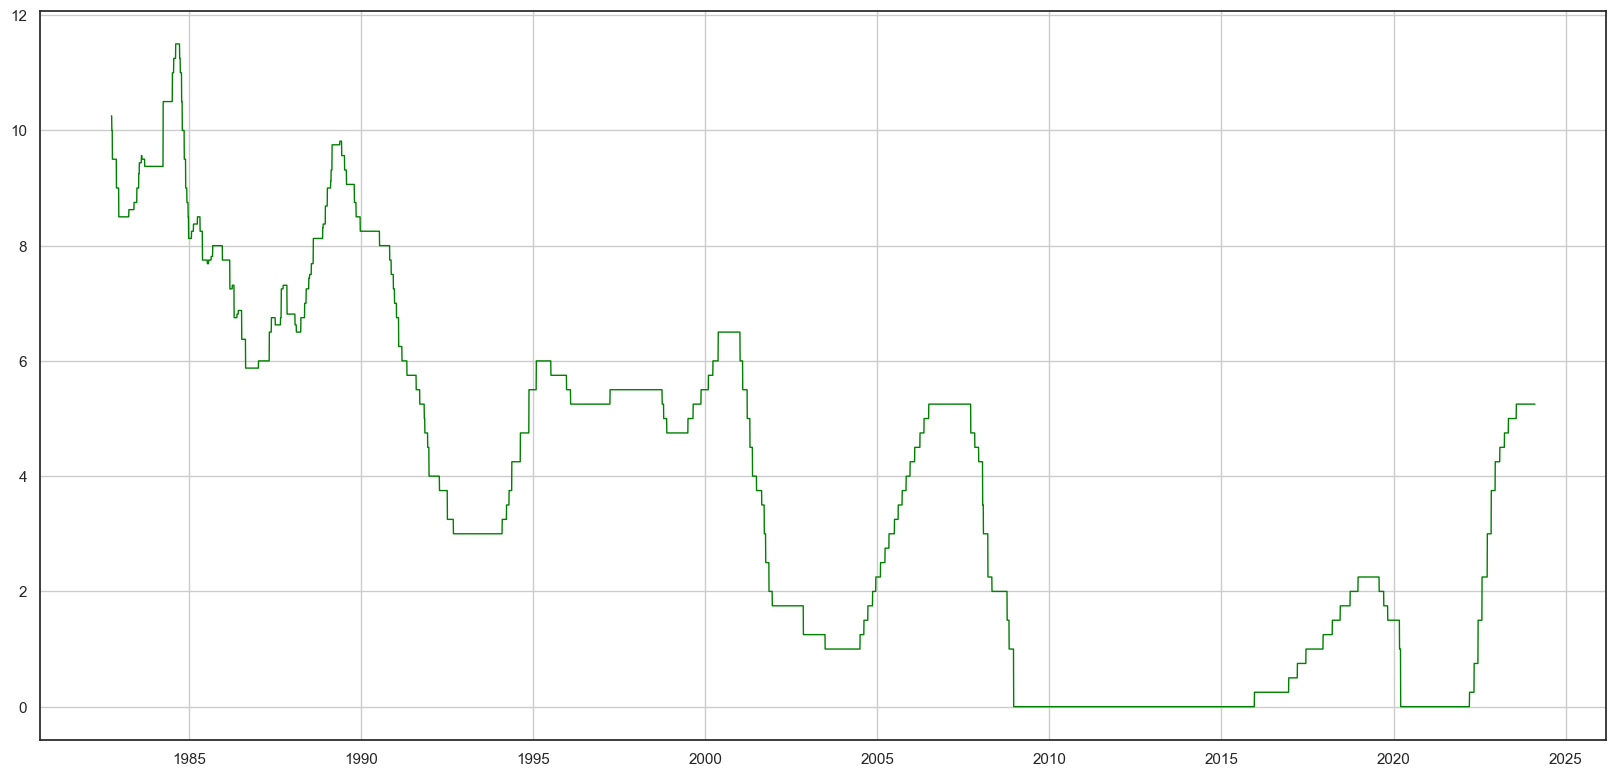

In [15]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

## rATIO FED ##

In [16]:
# Load FED Effective


dff = data_frames['Efective']

dff = dff.rename(columns={'Efective': 'DFF'})
# Add difference from previous value
dff['diff'] = dff['DFF'].diff()
dff

,DFF,diff
1954-07-01,1.13,NaN
1954-07-02,1.25,0.12
1954-07-03,1.25,0.00
1954-07-04,1.25,0.00
1954-07-05,0.88,-0.37
...,...,...
2024-02-04,5.33,0.00
2024-02-05,5.33,0.00
2024-02-06,5.33,0.00
2024-02-07,5.33,0.00


(848, 2)


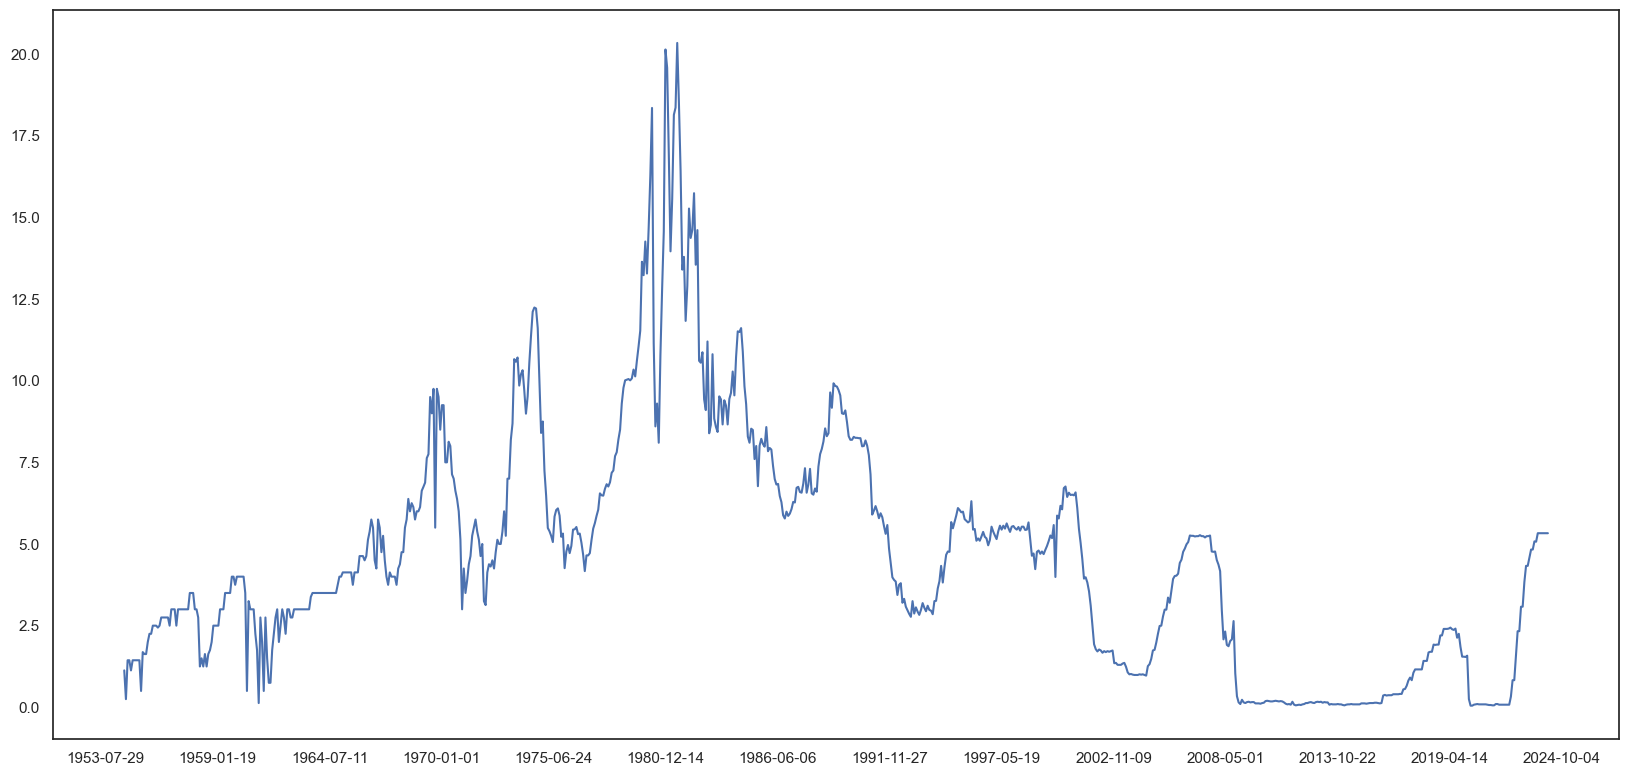

In [17]:
# Use every 30th row as it has too many data points
dff_30 = dff.iloc[::30, :]
print(dff_30.shape)

fig, ax = plt.subplots()
ax.plot(dff_30.index.values, dff_30['DFF'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### PIB REAL



In [18]:
# Load Real GDP
# Billions of Chained 2012 Dollars, Seasonally Adjusted Annual Rate

#filename = '../data/MarketData/Quandl/FRED_GDPC1.csv'

#gdpc1 = pd.read_csv(filename, names=['DATE', 'GDPC1'], header=0)
#gdpc1 = gdpc1.set_index(pd.to_datetime(gdpc1['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])

gdpc1 = data_frames['GDPC1']
# Add difference from previous value
gdpc1['diff_prev'] = gdpc1['GDPC1'].diff() / gdpc1['GDPC1'].shift(1) * 100
gdpc1['diff_year'] = gdpc1['GDPC1'].diff(periods=4) / gdpc1['GDPC1'].shift(4) * 100
gdpc1

,GDPC1,diff_prev,diff_year
1947-01-01,2182.681,NaN,NaN
1947-04-01,2176.892,-0.265224,NaN
1947-07-01,2172.432,-0.204879,NaN
1947-10-01,2206.452,1.565987,NaN
1948-01-01,2239.682,1.506038,2.611513
...,...,...,...
2022-10-01,21989.981,0.635422,0.651692
2023-01-01,22112.329,0.556381,1.717927
2023-04-01,22225.350,0.511122,2.382468
2023-07-01,22490.692,1.193871,2.926887


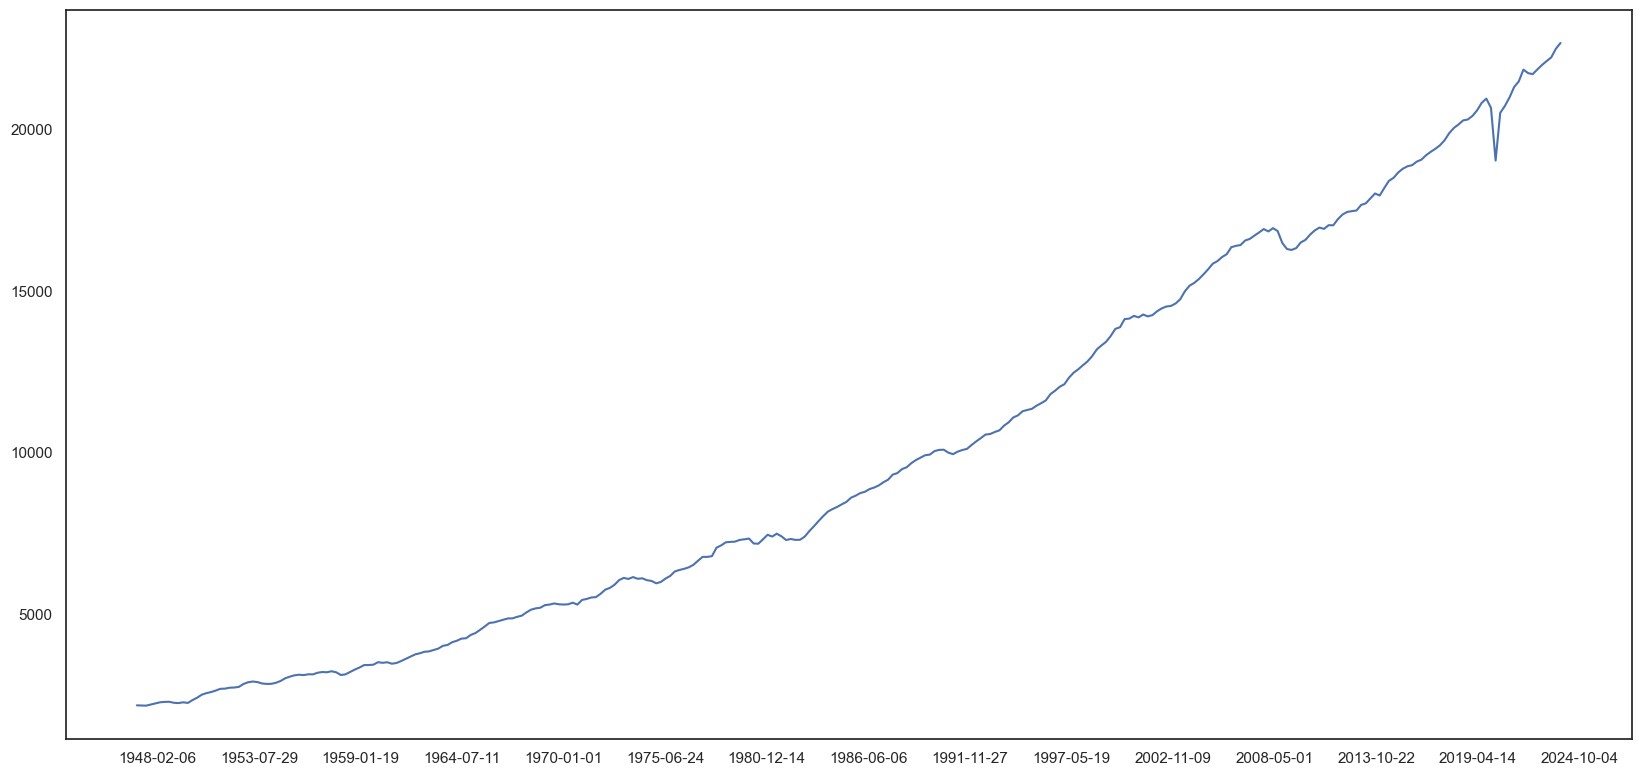

In [19]:
fig, ax = plt.subplots()
ax.plot(gdpc1.index.values, gdpc1['GDPC1'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### PIB POTENCIAL

In [20]:


gdppot = data_frames['Potential Gross Domestic Product']
gdppot = gdppot.rename(columns={'Potential Gross Domestic Product': 'GDPPOT'})
# Add difference from previous value
gdppot['diff_prev'] = gdppot['GDPPOT'].diff() / gdppot['GDPPOT'].shift(1) * 100
gdppot['diff_year'] = gdppot['GDPPOT'].diff(periods=4) / gdppot['GDPPOT'].shift(4) * 100
gdppot

,GDPPOT,diff_prev,diff_year
1949-01-01,2257.839360,NaN,NaN
1949-04-01,2287.466881,1.312207,NaN
1949-07-01,2318.403614,1.352445,NaN
1949-10-01,2347.972851,1.275414,NaN
1950-01-01,2379.334511,1.335691,5.381036
...,...,...,...
2033-10-01,27588.280000,0.454934,1.849426
2034-01-01,27712.650000,0.450807,1.836857
2034-04-01,27837.220000,0.449506,1.825209
2034-07-01,27961.070000,0.444908,1.812343


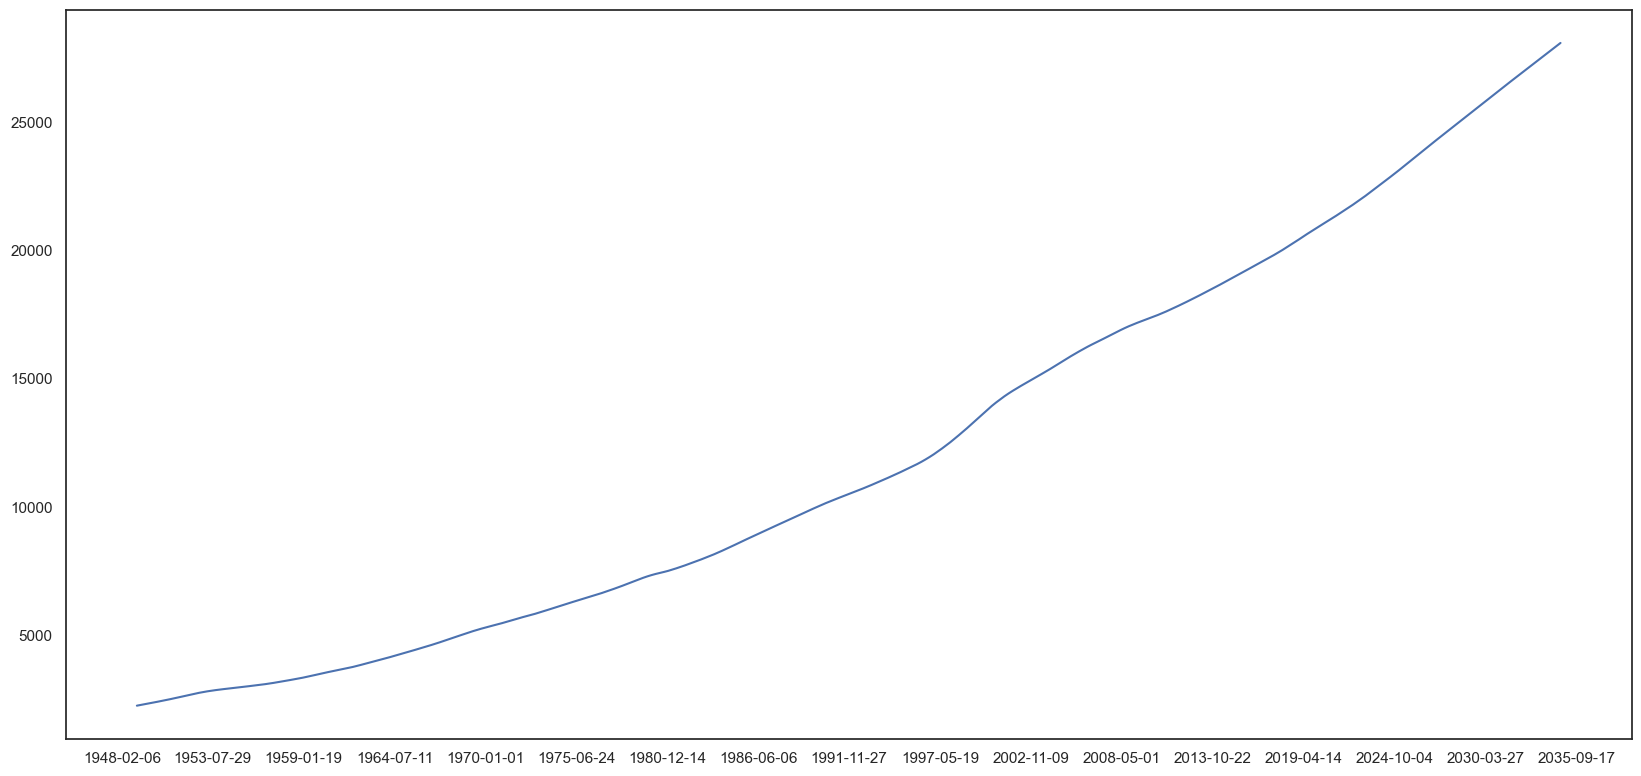

In [21]:
fig, ax = plt.subplots()
ax.plot(gdppot.index.values, gdppot['GDPPOT'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

###  PCE 



In [22]:
# Load Personal Consumption Expenditures Excluding Food and Energy (Chain-Type Price Index)


pcepilfe = data_frames['PCEPILFE']


# Add difference from previous value
pcepilfe['diff_prev'] = pcepilfe['PCEPILFE'].diff() / pcepilfe['PCEPILFE'].shift(1) * 100
pcepilfe['diff_year'] = pcepilfe['PCEPILFE'].diff(periods=12) / pcepilfe['PCEPILFE'].shift(12) * 100
pcepilfe

,PCEPILFE,diff_prev,diff_year
1959-01-01,15.501,NaN,NaN
1959-02-01,15.513,0.077414,NaN
1959-03-01,15.531,0.116032,NaN
1959-04-01,15.570,0.251111,NaN
1959-05-01,15.589,0.122030,NaN
...,...,...,...
2023-08-01,119.449,0.098046,3.726185
2023-09-01,119.842,0.329011,3.592483
2023-10-01,120.010,0.140185,3.379362
2023-11-01,120.088,0.064995,3.153320


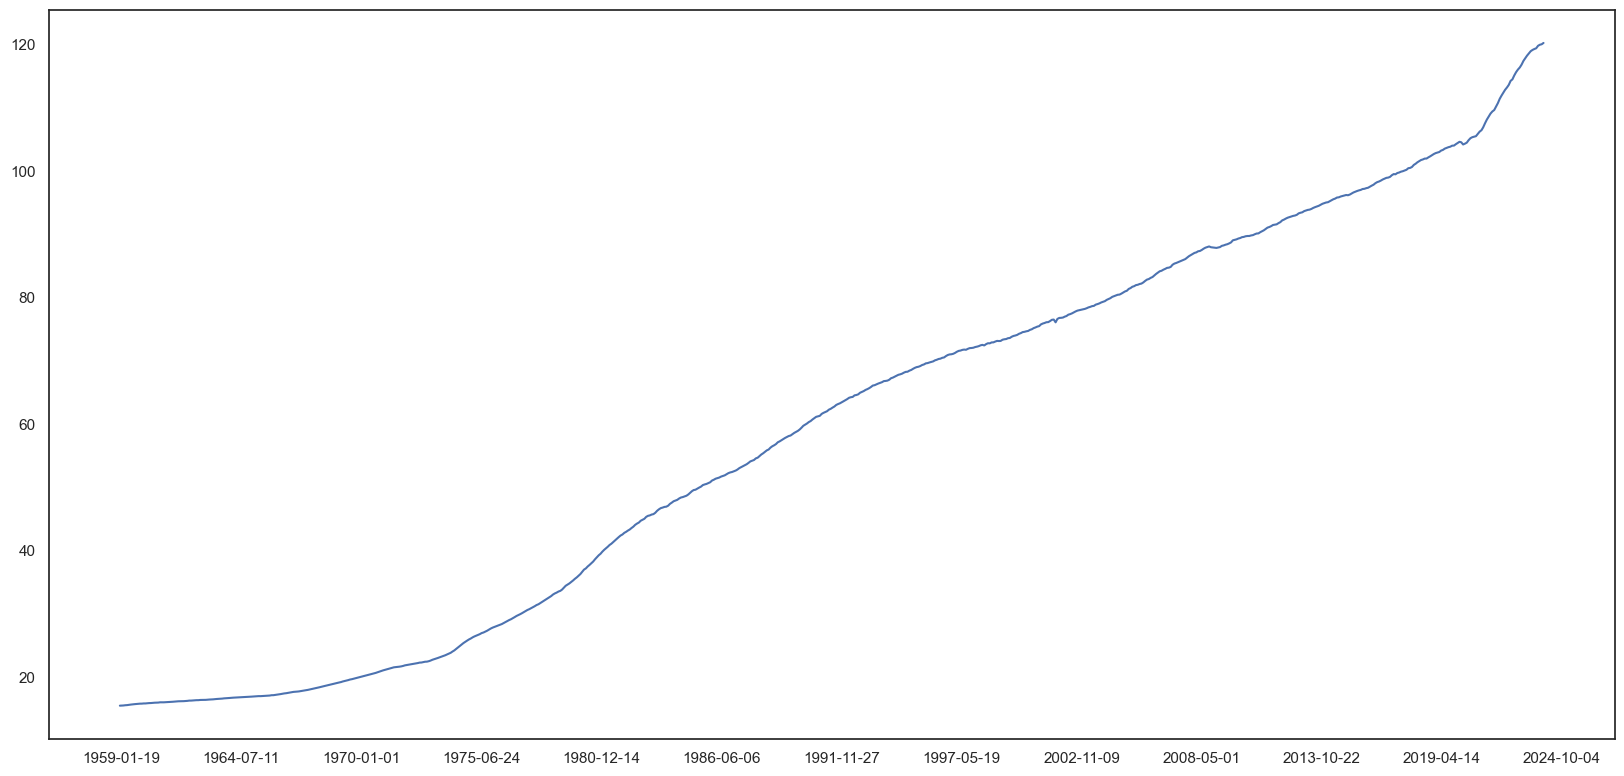

In [23]:
fig, ax = plt.subplots()
ax.plot(pcepilfe.index.values, pcepilfe['PCEPILFE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

###  CPI



In [24]:


cpiaucsl = data_frames['CPIAUCSL']
# Add difference from previous value
cpiaucsl['diff_prev'] = cpiaucsl['CPIAUCSL'].diff() / cpiaucsl['CPIAUCSL'].shift(1) * 100
cpiaucsl['diff_year'] = cpiaucsl['CPIAUCSL'].diff(periods=12) / cpiaucsl['CPIAUCSL'].shift(12) * 100
cpiaucsl


,CPIAUCSL,diff_prev,diff_year
1947-01-01,21.480,NaN,NaN
1947-02-01,21.620,0.651769,NaN
1947-03-01,22.000,1.757632,NaN
1947-04-01,22.000,0.000000,NaN
1947-05-01,21.950,-0.227273,NaN
...,...,...,...
2023-08-01,306.187,0.511772,3.718721
2023-09-01,307.288,0.359584,3.694055
2023-10-01,307.531,0.079079,3.245787
2023-11-01,308.024,0.160309,3.139482


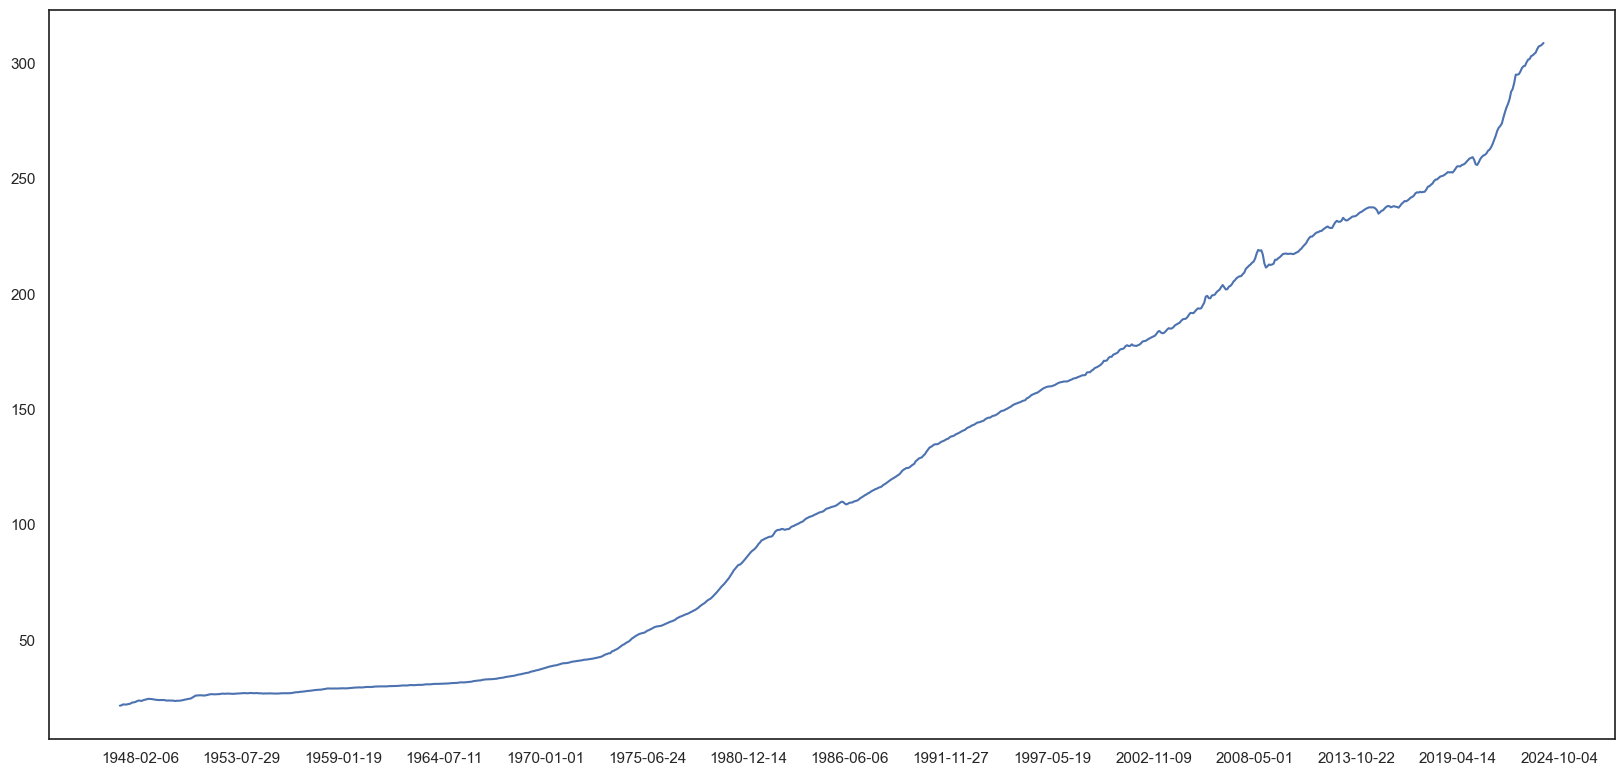

In [25]:
fig, ax = plt.subplots()
ax.plot(cpiaucsl.index.values, cpiaucsl['CPIAUCSL'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Unemployment


In [26]:


unrate = data_frames['Unemployment Rate']
unrate = unrate.rename(columns={'Unemployment Rate': 'UNRATE'})

unrate['UNRATE'] = unrate['UNRATE'] * -1
# Add difference from previous value
unrate['diff_prev'] = unrate['UNRATE'].diff()
unrate['diff_year'] = unrate['UNRATE'].diff(periods=12)
unrate

,UNRATE,diff_prev,diff_year
1948-01-01,-3.4,NaN,NaN
1948-02-01,-3.8,-0.4,NaN
1948-03-01,-4.0,-0.2,NaN
1948-04-01,-3.9,0.1,NaN
1948-05-01,-3.5,0.4,NaN
...,...,...,...
2023-09-01,-3.8,0.0,-0.3
2023-10-01,-3.8,0.0,-0.2
2023-11-01,-3.7,0.1,-0.1
2023-12-01,-3.7,0.0,-0.2


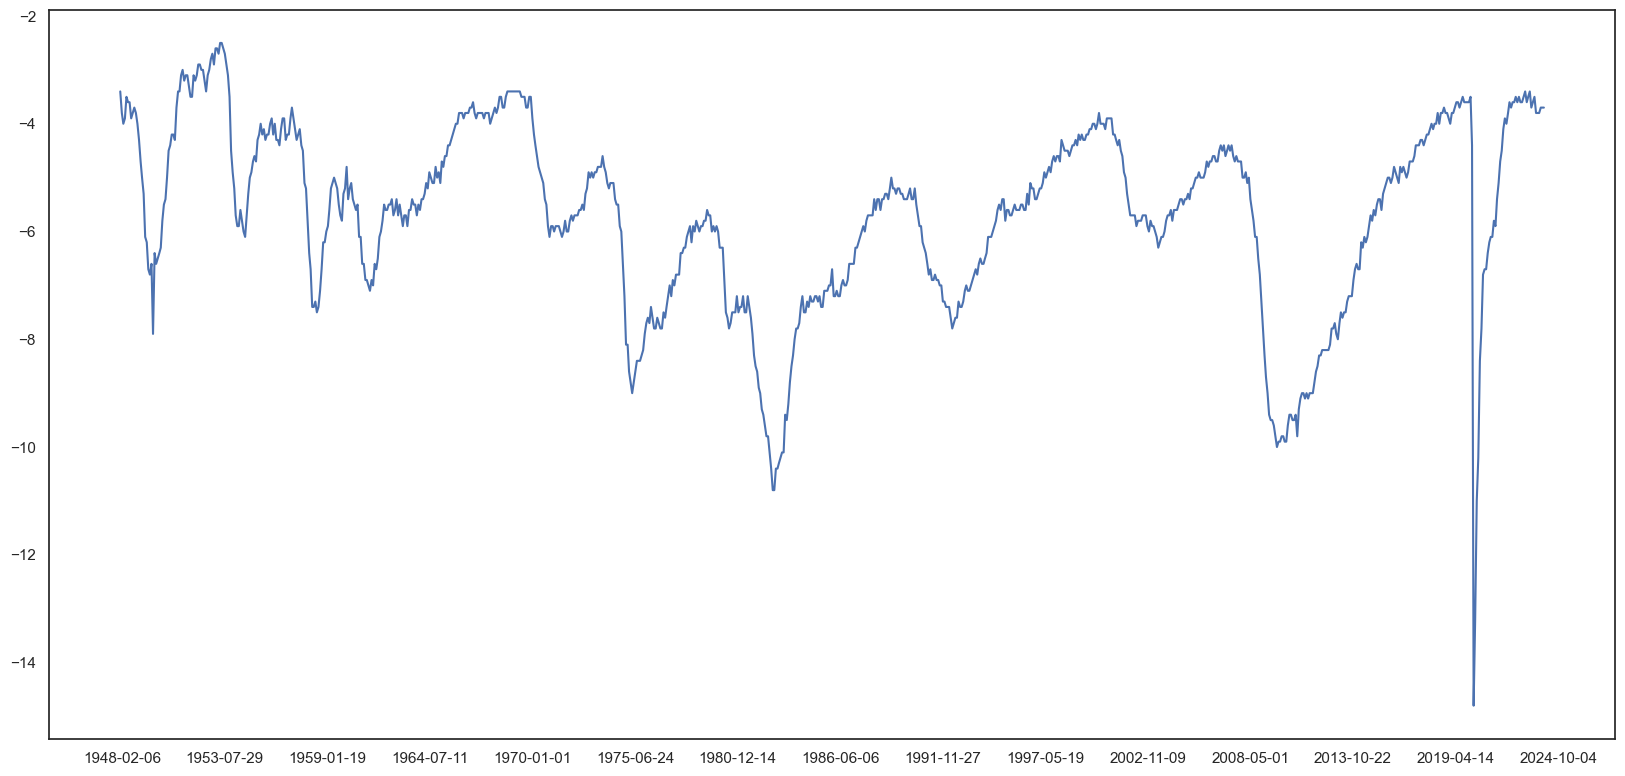

In [27]:
fig, ax = plt.subplots()
ax.plot(unrate.index.values, unrate['UNRATE'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Employment

In [28]:


payems = data_frames['Total Nonfarm Payrolls (Employment)']
payems = payems.rename(columns={'Total Nonfarm Payrolls (Employment)': 'PAYEMS'})

# Add difference from previous value
payems['diff_prev'] = payems['PAYEMS'].diff()
payems['diff_year'] = payems['PAYEMS'].diff(periods=12)
payems

,PAYEMS,diff_prev,diff_year
1939-01-01,29923.0,NaN,NaN
1939-02-01,30100.0,177.0,NaN
1939-03-01,30280.0,180.0,NaN
1939-04-01,30094.0,-186.0,NaN
1939-05-01,30299.0,205.0,NaN
...,...,...,...
2023-09-01,156667.0,246.0,3131.0
2023-10-01,156832.0,165.0,2935.0
2023-11-01,157014.0,182.0,2859.0
2023-12-01,157347.0,333.0,3056.0


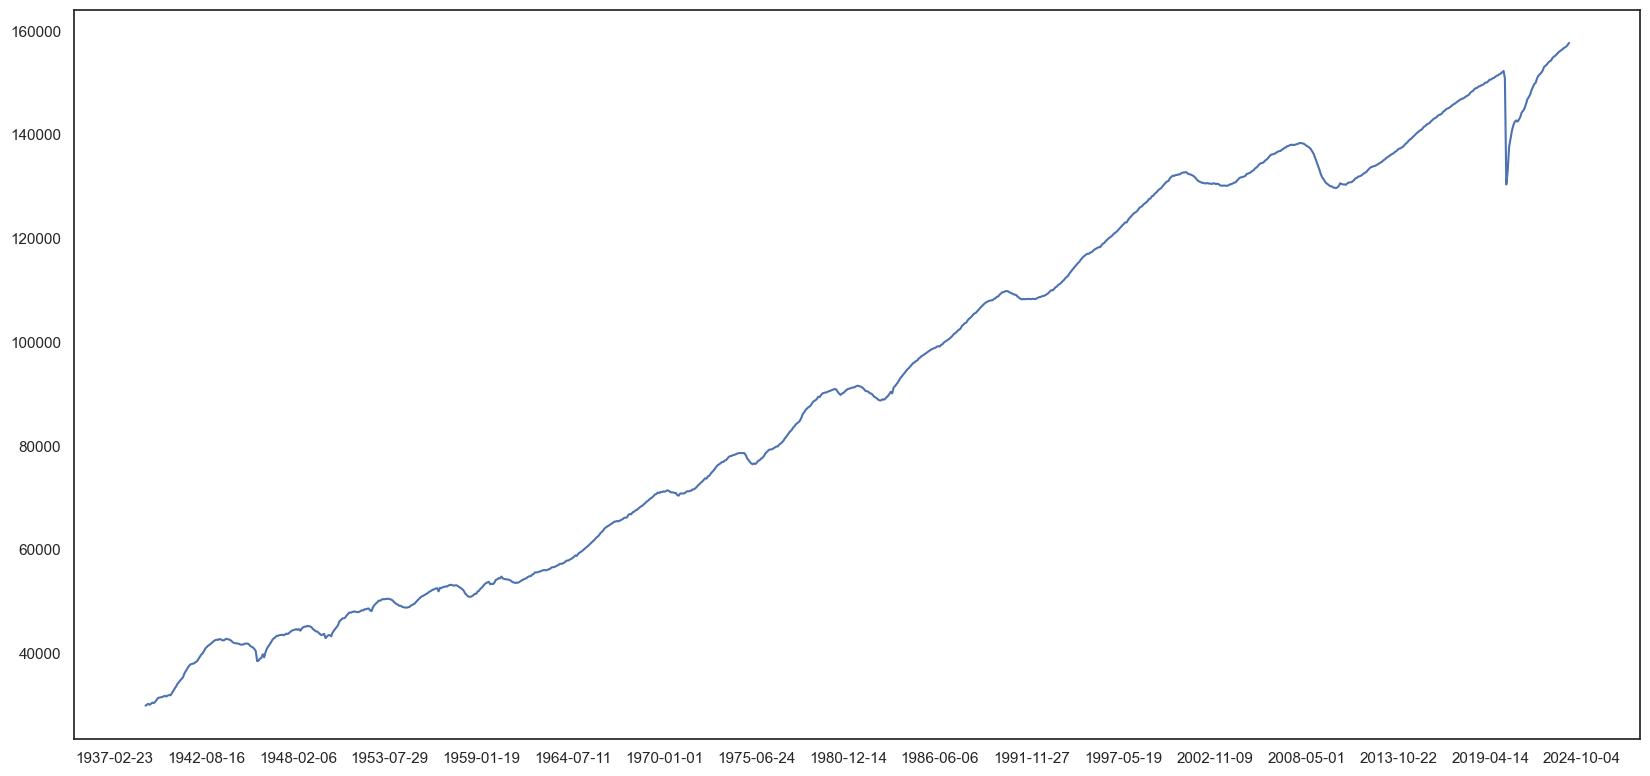

In [29]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['PAYEMS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

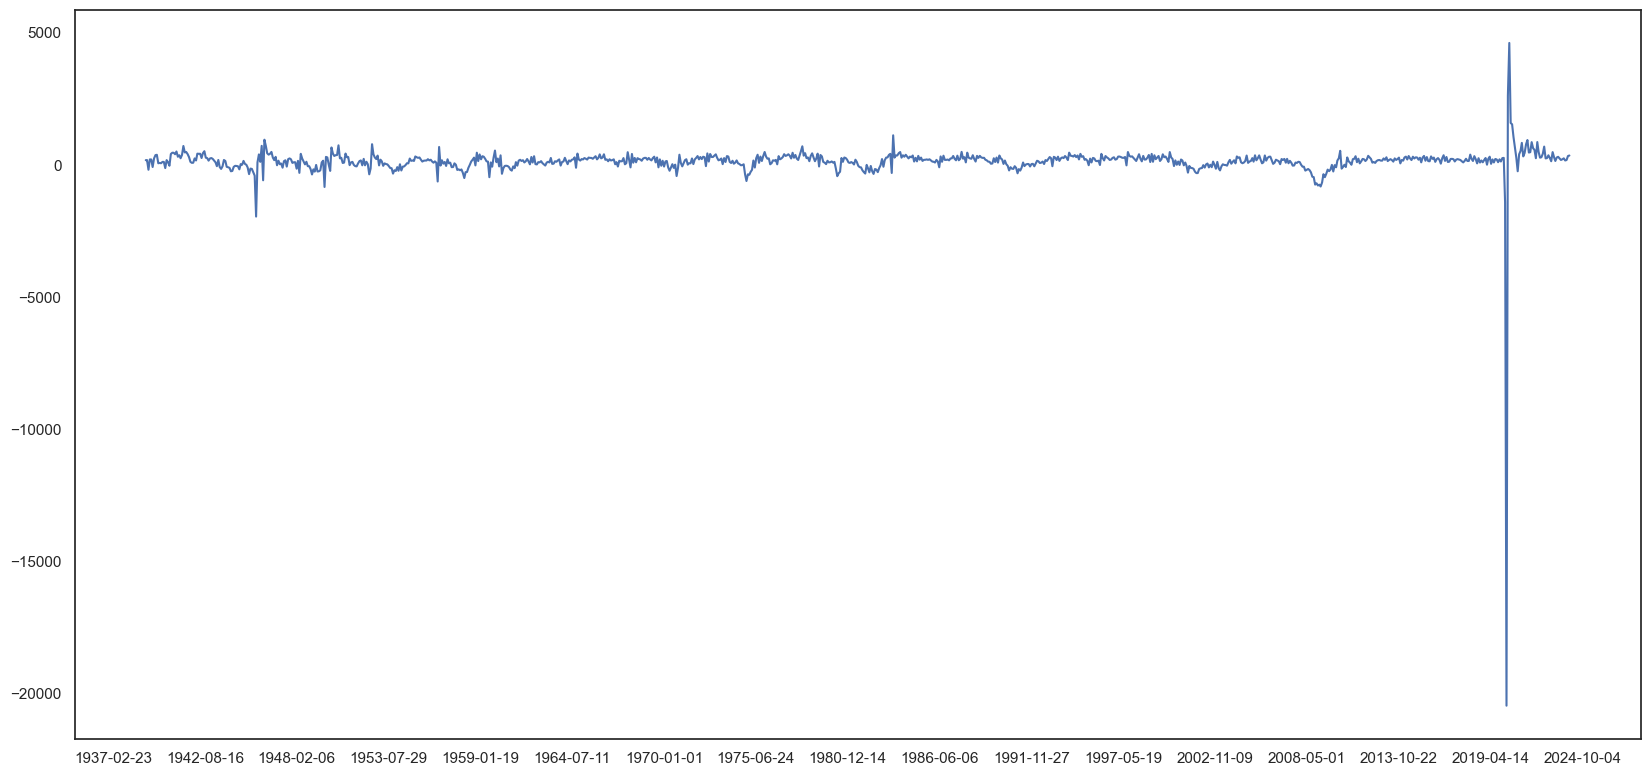

In [30]:
fig, ax = plt.subplots()
ax.plot(payems.index.values, payems['diff_prev'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Retail Sales


In [31]:


rrsfs = data_frames['RRSFS']

# Add difference from previous value
rrsfs['diff_prev'] = rrsfs['RRSFS'].diff() / rrsfs['RRSFS'].shift(1) * 100
rrsfs['diff_year'] = rrsfs['RRSFS'].diff(periods=12) / rrsfs['RRSFS'].shift(12) * 100
rrsfs


,RRSFS,diff_prev,diff_year
1992-01-01,118651.0,NaN,NaN
1992-02-01,118480.0,-0.144120,NaN
1992-03-01,117700.0,-0.658339,NaN
1992-04-01,118156.0,0.387426,NaN
1992-05-01,118548.0,0.331765,NaN
...,...,...,...
2023-08-01,228468.0,0.225044,-0.851882
2023-09-01,229525.0,0.462647,0.291009
2023-10-01,228767.0,-0.330247,-1.008235
2023-11-01,229197.0,0.187964,0.802206


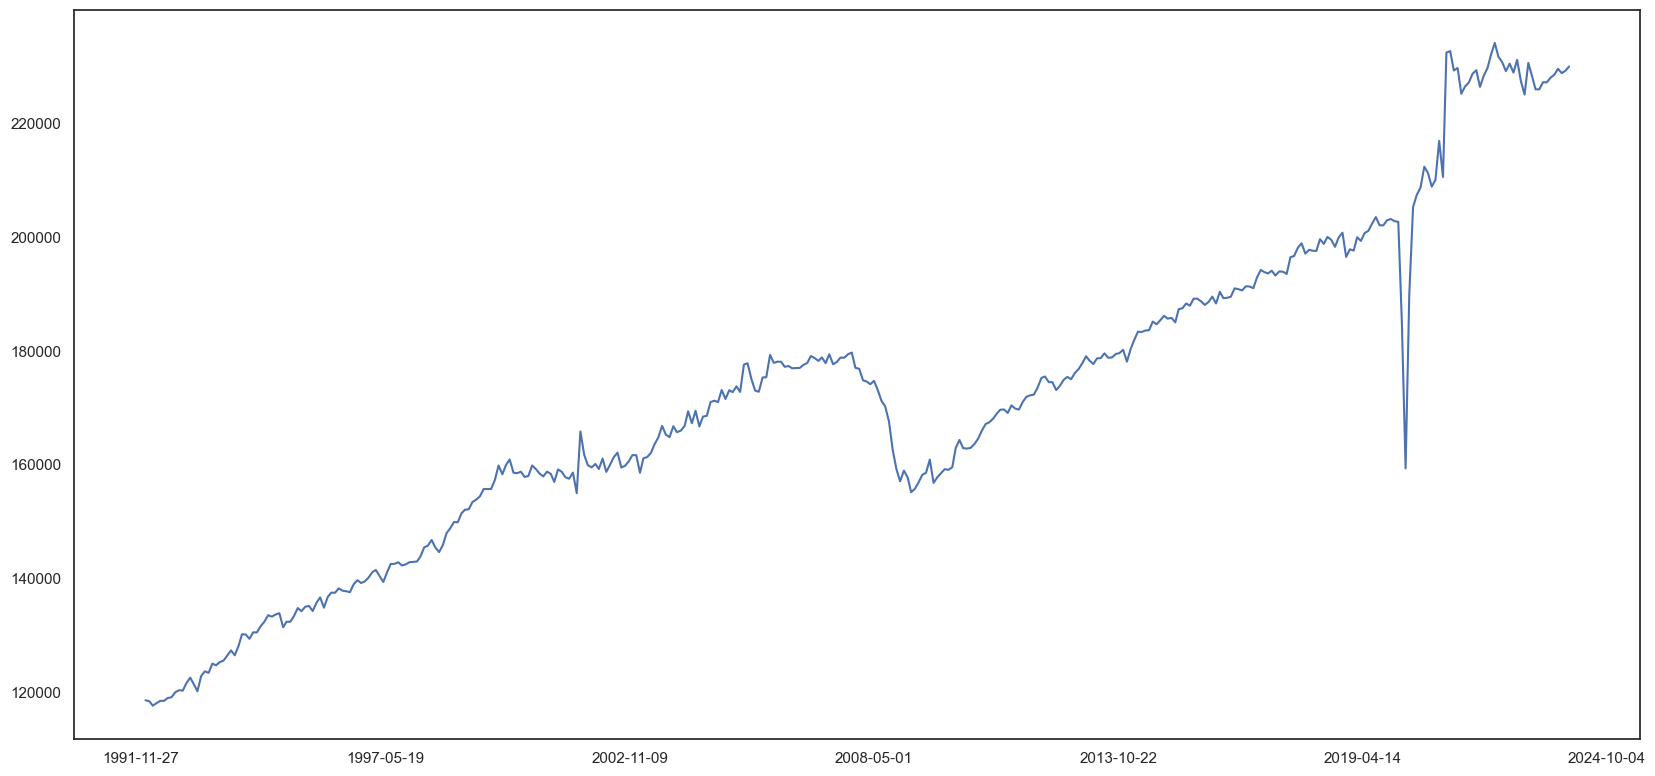

In [32]:
fig, ax = plt.subplots()
ax.plot(rrsfs.index.values, rrsfs['RRSFS'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### New Home Sales


In [33]:
#filename = '../data/MarketData/Quandl/FRED_HSN1F.csv'

#hsn1f = pd.read_csv(filename, names=['DATE', 'HSN1F'], header=0)
#hsn1f = hsn1f.set_index(pd.to_datetime(hsn1f['DATE'], format="%Y-%m-%d")).drop(columns=['DATE'])

hsn1f = data_frames['HSN1F']


# Add difference from previous value
hsn1f['diff_prev'] = hsn1f['HSN1F'].diff() / hsn1f['HSN1F'].shift(1) * 100
hsn1f['diff_year'] = hsn1f['HSN1F'].diff(periods=12) / hsn1f['HSN1F'].shift(12) * 100
hsn1f

,HSN1F,diff_prev,diff_year
1963-01-01,591.0,NaN,NaN
1963-02-01,464.0,-21.489002,NaN
1963-03-01,461.0,-0.646552,NaN
1963-04-01,605.0,31.236443,NaN
1963-05-01,586.0,-3.140496,NaN
...,...,...,...
2023-08-01,654.0,-10.164835,2.507837
2023-09-01,698.0,6.727829,23.104056
2023-10-01,676.0,-3.151862,17.157712
2023-11-01,615.0,-9.023669,5.670103


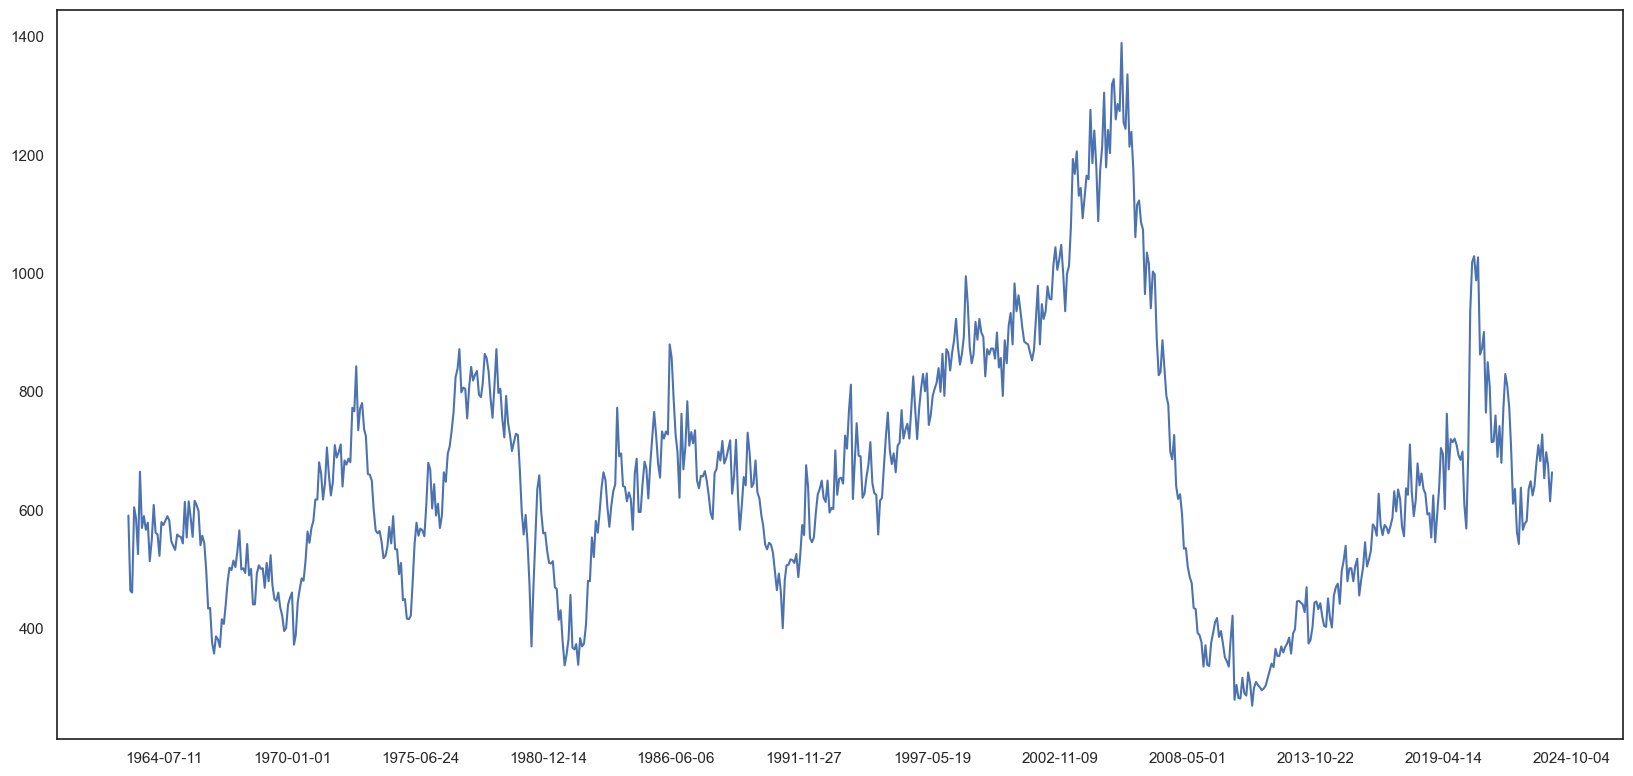

In [34]:
fig, ax = plt.subplots()
ax.plot(hsn1f.index.values, hsn1f['HSN1F'].values)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.show()

### Treasury Yield


In [35]:
filename = '../data/MarketData/Quandl/USTREASURY_YIELD.csv'

treasury_q = pd.read_csv(filename, header=0)

treasury_q = treasury_q.set_index(pd.to_datetime(treasury_q['Date'], format="%Y-%m-%d")).drop(columns=['Date'])
treasury_q


,1 MO,2 MO,3 MO,6 MO,1 YR,2 YR,3 YR,5 YR,7 YR,10 YR,20 YR,30 YR
Date,,,,,,,,,,,,
1990-01-02,NaN,NaN,7.83,7.89,7.81,7.87,7.90,7.87,7.98,7.94,NaN,8.00
1990-01-03,NaN,NaN,7.89,7.94,7.85,7.94,7.96,7.92,8.04,7.99,NaN,8.04
1990-01-04,NaN,NaN,7.84,7.90,7.82,7.92,7.93,7.91,8.02,7.98,NaN,8.04
1990-01-05,NaN,NaN,7.79,7.85,7.79,7.90,7.94,7.92,8.03,7.99,NaN,8.06
1990-01-08,NaN,NaN,7.79,7.88,7.81,7.90,7.95,7.92,8.05,8.02,NaN,8.09
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-19,5.51,5.51,5.43,5.35,4.93,4.41,4.15,3.94,3.96,3.93,4.23,4.03
2023-12-20,5.50,5.49,5.44,5.33,4.88,4.34,4.06,3.86,3.88,3.86,4.17,3.98
2023-12-21,5.54,5.53,5.42,5.31,4.84,4.33,4.06,3.87,3.91,3.89,4.19,4.03


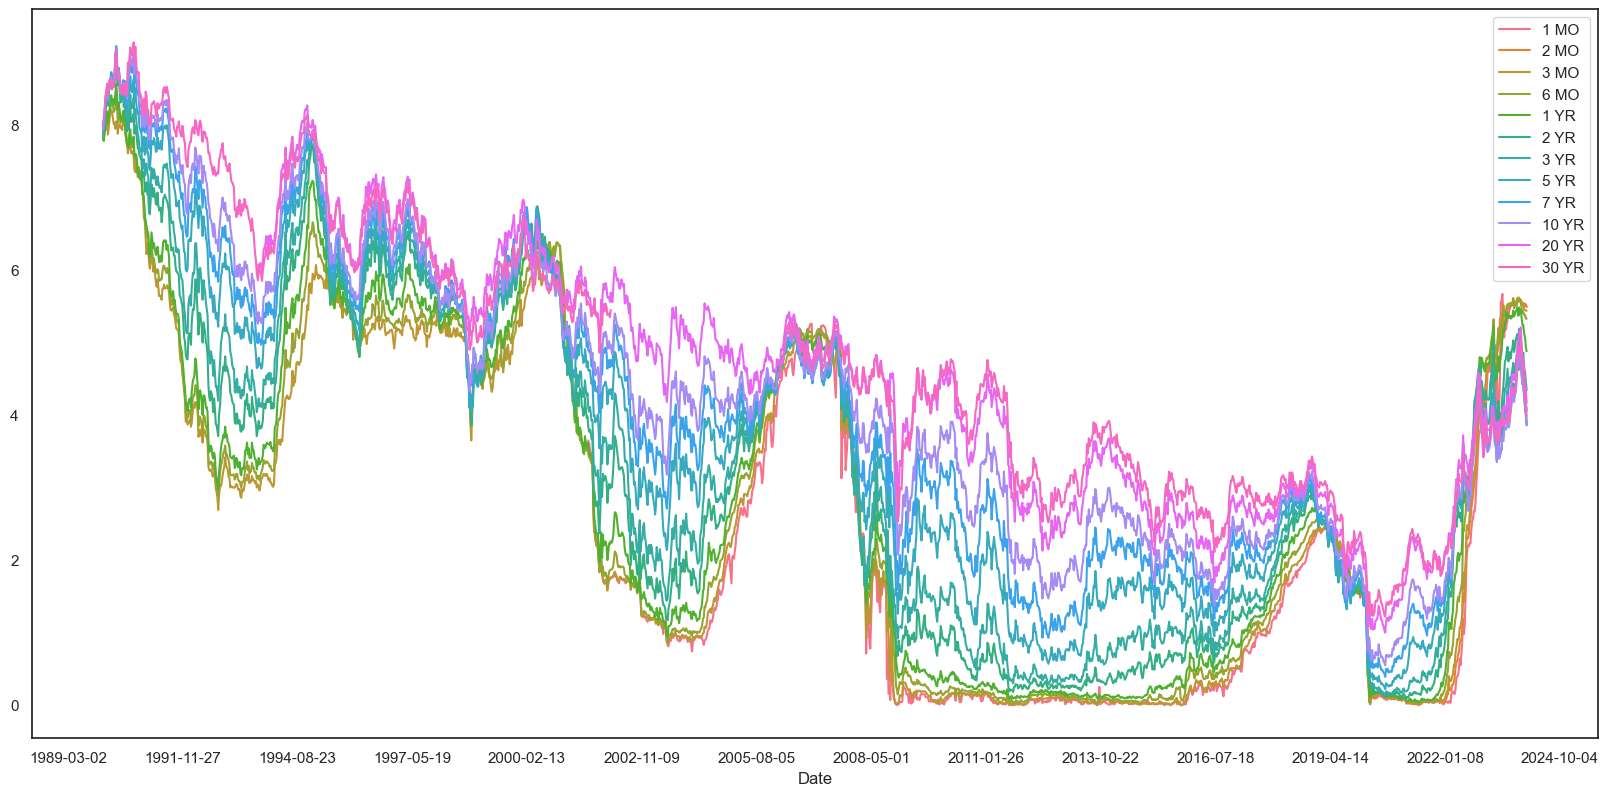

In [36]:
# Use every 5th row as it has too many data points
treasury_q_5 = treasury_q.iloc[::5, :]

fig, ax = plt.subplots()
ax = sns.lineplot(data = treasury_q_5, dashes=False)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.show()

# PREPROCESADO

## AÑADIR TIPO DE INTERES Y LA DECISION

In [37]:

# Listas para almacenar los resultados procesados
rate_list = []         # Lista para almacenar el tipo objetivo tres días después de la reunión
decision_list = []     # Lista para almacenar la decisión sobre la tasa (hike, keep, lower)
rate_diff_list = []    # Lista para almacenar la diferencia entre el tipo objetivo tres días después y el del día anterior

# Iteración sobre las fechas en el calendario FOMC
for i in tqdm(range(len(fomc_calendar))):
    not_found = True  # Variable para indicar si no se encontró una coincidencia en las fechas

    # Iteración sobre las fechas en el DataFrame fedrate_df
    for j in range(len(fedrate_df)):
        # Verifica si las fechas coinciden entre fomc_calendar y fedrate_df
        if fomc_calendar.index[i] == fedrate_df.index[j]:
            not_found = False  # Se encontró una coincidencia
            
            # Añade el tipo objetivo tres días después de la reunión al rate_list
            rate_list.append(float(fedrate_df['Rate'].iloc[j+3]))
            
            # Calcula la diferencia entre el tipo objetivo tres días después y el del día anterior
            rate_diff_list.append(float(fedrate_df['Rate'].iloc[j+3]) - float(fedrate_df['Rate'].iloc[j-1]))
            
            # Determina la decisión sobre la tasa basada en la comparación entre el día anterior y tres días después
            if fedrate_df['Rate'].iloc[j-1] == fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(0)  # No hubo cambio en la tasa
            elif fedrate_df['Rate'].iloc[j-1] < fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(1)  # La tasa se incrementó
            elif fedrate_df['Rate'].iloc[j-1] > fedrate_df['Rate'].iloc[j+3]:
                decision_list.append(-1)  # La tasa se redujo
            
            break  # Termina la búsqueda una vez que se encuentra la fecha en fedrate_df
    
    # Si no se encontró coincidencia para la fecha en fomc_calendar, se añaden valores NaN a las listas
    if not_found:
        rate_list.append(np.nan)
        decision_list.append(np.nan)
        rate_diff_list.append(np.nan)

# Actualización del DataFrame fomc_calendar con los resultados procesados
fomc_calendar.loc[:, 'Rate'] = rate_list        # Asigna el tipo objetivo tres días después a la columna 'Rate'
fomc_calendar.loc[:, 'RateDiff'] = rate_diff_list  # Asigna la diferencia de tasas a la columna 'RateDiff'
fomc_calendar.loc[:, 'RateDecision'] = decision_list  # Asigna la decisión sobre la tasa a la columna 'RateDecision'

# Convierte la columna 'RateDecision' al tipo de datos 'Int8' para optimizar el uso de memoria
fomc_calendar['RateDecision'] = fomc_calendar['RateDecision'].astype('Int8')

# Retorna el DataFrame actualizado con las nuevas columnas 'Rate', 'RateDiff' y 'RateDecision'
fomc_calendar

C:\Users\luisl\AppData\Local\Temp\ipykernel_11160\2190436413.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fomc_calendar.loc[:,'Rate'] = rate_list
C:\Users\luisl\AppData\Local\Temp\ipykernel_11160\2190436413.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fomc_calendar.loc[:,'RateDiff'] = rate_diff_list
C:\Users\luisl\AppData\Local\Temp\ipykernel_11160\2190436413.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-0.5,-1
1982-11-16,False,False,False,Paul Volcker,9.0,-0.5,-1
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0
...,...,...,...,...,...,...,...
2024-06-12,False,True,False,None,NaN,NaN,<NA>
2024-07-31,False,False,False,None,NaN,NaN,<NA>
2024-09-18,False,True,False,None,NaN,NaN,<NA>


In [38]:
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
2024-03-20,False,True,False,None,NaN,NaN,<NA>
2024-05-01,False,False,False,None,NaN,NaN,<NA>
2024-06-12,False,True,False,None,NaN,NaN,<NA>
2024-07-31,False,False,False,None,NaN,NaN,<NA>
2024-09-18,False,True,False,None,NaN,NaN,<NA>
2024-11-07,False,False,False,None,NaN,NaN,<NA>
2024-12-18,False,True,False,None,NaN,NaN,<NA>


In [39]:
# Remove the future date
fomc_calendar = fomc_calendar.loc[fomc_calendar.index < dt.datetime.now()]

# Confirm no null rate remains
fomc_calendar.loc[fomc_calendar['Rate'].isnull()]

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,


In [40]:
fedrate_df.head()

,Rate,diff
1982-09-27,10.25,NaN
1982-09-28,10.25,0.00
1982-09-29,10.25,0.00
1982-09-30,10.25,0.00
1982-10-01,10.00,-0.25


In [41]:
fomc_calendar.tail()

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
2023-07-26,False,False,False,Jerome Powell,5.25,0.25,1
2023-09-20,False,True,False,Jerome Powell,5.25,0.00,0
2023-11-01,False,False,False,Jerome Powell,5.25,0.00,0
2023-12-13,False,True,False,Jerome Powell,5.25,0.00,0
2024-01-31,False,False,False,None,5.25,0.00,0


## AÑADIR EL QE COMO EVENTO BAJISTA


In [43]:
fomc_calendar

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.50,-0.50,-1
1982-11-16,False,False,False,Paul Volcker,9.00,-0.50,-1
1982-12-21,False,False,False,Paul Volcker,8.50,0.00,0
1983-01-14,False,False,True,Paul Volcker,8.50,0.00,0
1983-01-21,False,False,True,Paul Volcker,8.50,0.00,0
...,...,...,...,...,...,...,...
2023-07-26,False,False,False,Jerome Powell,5.25,0.25,1
2023-09-20,False,True,False,Jerome Powell,5.25,0.00,0
2023-11-01,False,False,False,Jerome Powell,5.25,0.00,0


In [44]:
# Se añade la fecha 2008-11-25 a fomc_calendar cuando se anunció QE por primera vez pero no estaba en el calendario FOMC original.
# Se marca RateDecision = -1 (baja) incluso cuando la tasa no cambió pero se anunciaron medidas cuantitativas adicionales.

# Se asignan los eventos de expansión de QE como eventos de reducción de tasa (-0.5% efecto).
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2008,11,25), ['unscheduled', 'forecast', 'confcall', 'ChairPerson', 'Rate', 'RateDiff', 'RateDecision']] = (True, False, False, 'Ben Bernanke', 0, -1, -1)  # QE1 anunciado
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2009,3,18), ['RateDecision', 'RateDiff']] = (-1, -0.5)  # QE1 Expandido
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2010,11,3), ['RateDecision', 'RateDiff']] = (-1, -0.5)  # QE2 Anunciado
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2011,9,21), ['RateDecision', 'RateDiff']] = (-1, -0.5)  # Operation Twist Anunciado
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,6,20), ['RateDecision', 'RateDiff']] = (-1, -0.5)  # Operation Twist Extendido
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,9,13), ['RateDecision', 'RateDiff']] = (-1, -0.5)  # QE3 Anunciado
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2012,12,12), ['RateDecision', 'RateDiff']] = (-1, -0.5)  # QE3 Expandido

# Se marca el fin del QE como un aumento de la tasa
fomc_calendar.loc[fomc_calendar.index == dt.datetime(2013,6,19), ['RateDecision', 'RateDiff']] = (1, 1)  # Tapering Anunciado
fomc_calendar.loc['2013-12-18', ['RateDecision', 'RateDiff']] = (1, 1)  # Comienza el Tapering
fomc_calendar.loc['2014-10-29', ['RateDecision', 'RateDiff']] = (1, 0.5)  # QE3 Terminado
fomc_calendar.loc['2017-06-14', ['RateDecision', 'RateDiff']] = (1, 0.5)  # Normalización del Balance Anunciada
fomc_calendar.loc['2017-09-20', ['RateDecision', 'RateDiff']] = (1, 0.5)  # Normalización del Balance Comienza en Octubre

# Se convierten los índices a tipo de dato datetime y se ordena el DataFrame por fechas ascendentes
fomc_calendar.index = pd.to_datetime(fomc_calendar.index)
fomc_calendar.sort_index(ascending=True, inplace=True)

# Se imprime el DataFrame fomc_calendar actualizado con los eventos de QE y sus efectos en las decisiones de tasa
fomc_calendar


C:\Users\luisl\AppData\Local\Temp\ipykernel_11160\2430836534.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fomc_calendar.loc['2017-06-14', ['RateDecision', 'RateDiff']] = (1, 0.5) # Signaled Balance Sheet Normalization


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision
date,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.50,-0.50,-1
1982-11-16,False,False,False,Paul Volcker,9.00,-0.50,-1
1982-12-21,False,False,False,Paul Volcker,8.50,0.00,0
1983-01-14,False,False,True,Paul Volcker,8.50,0.00,0
1983-01-21,False,False,True,Paul Volcker,8.50,0.00,0
...,...,...,...,...,...,...,...
2023-07-26,False,False,False,Jerome Powell,5.25,0.25,1
2023-09-20,False,True,False,Jerome Powell,5.25,0.00,0
2023-11-01,False,False,False,Jerome Powell,5.25,0.00,0


In [45]:

fomc_calendar['RateChanged'] = fomc_calendar['RateDecision'].apply(lambda x: 0 if x == 0 else 1)


<Axes: xlabel='date', ylabel='RateDecision'>

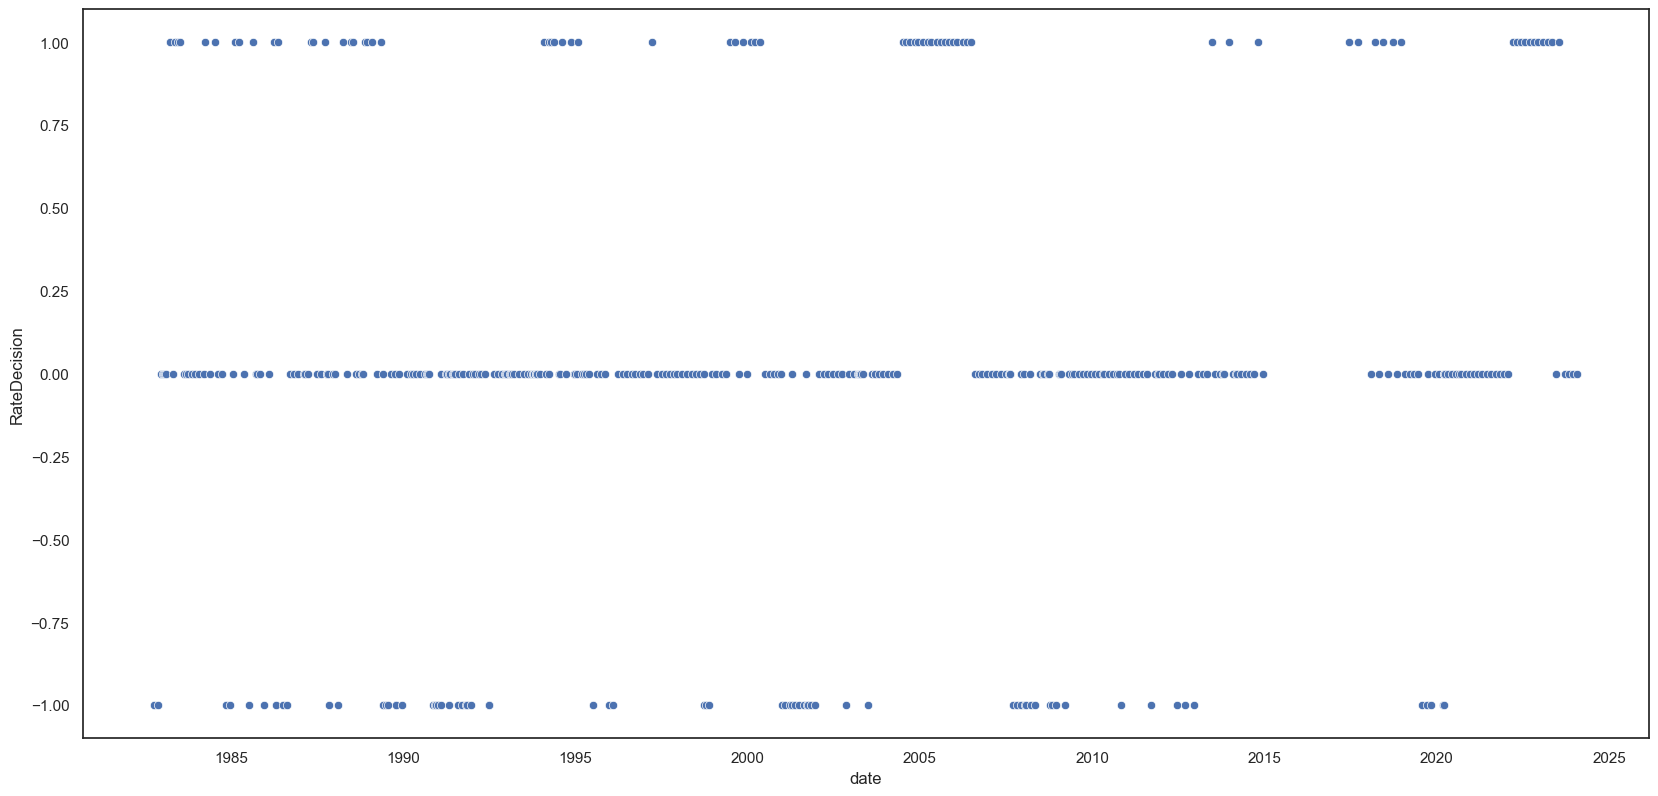

In [46]:
sns.scatterplot(x=fomc_calendar.index, y=fomc_calendar['RateDecision'].apply(lambda x: float(x)))

## Add major economic indices

In [47]:
def get_available_latest(train_df, index_df, value_col, diff_prev_col, diff_year_col, date_offset):
    '''
    Retorna el índice económico más reciente disponible para cada fila de train_df.
    
    INPUTS:
        train_df: DataFrame de entrenamiento donde el índice debe estar en formato datetime.
        index_df: DataFrame de índice donde el índice debe estar en formato datetime y ordenado cronológicamente.
        value_col: Nombre de la columna que contiene el valor en index_df.
        diff_prev_col: Nombre de la columna que contiene la diferencia desde el período anterior en index_df.
        diff_year_col: Nombre de la columna que contiene la diferencia desde el mismo período del año anterior en index_df.
        date_offset: Utilizar relativedelta para el desplazamiento cuando se publica el índice.
        
    OUTPUTS:
        date_list: Lista de fechas que coinciden con train_df.index.
        value_list: Lista de valores correspondientes a date_list.
        diff_prev_list: Lista de valores de diferencias desde el período anterior para date_list.
        diff_year_list: Lista de valores de diferencias desde el mismo período del año anterior para date_list.
    '''
    
    date_list, value_list, diff_prev_list, diff_year_list = [], [], [], []
    
    for i, row_data in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        not_available = True
        for j, row_index in index_df.sort_index(ascending=False).iterrows():
            if row_data.name > row_index.name + date_offset:
                date_list.append(row_index.name)
                value_list.append(row_index[value_col])
                diff_prev_list.append(row_index[diff_prev_col])
                diff_year_list.append(row_index[diff_year_col])
                not_available = False
                break
        if not_available:
            date_list.append(None)
            value_list.append(None)
            diff_prev_list.append(None)
            diff_year_list.append(None)
    
    if train_df.shape[0] != len(date_list):
        print("¡train_df tiene {} filas pero se devolvieron {} filas de index_df!".format(train_df.shape[0], len(date_list)))
    
    return date_list, value_list, diff_prev_list, diff_year_list


In [48]:
def add_market_data(calendar_df, window=1):
    '''
    Busca los datos de mercado más recientes disponibles utilizando get_available_latest y devuelve un nuevo DataFrame con los datos de mercado.
    Se aplica un promedio móvil a los datos de mercado para el tamaño de ventana dado.
    '''
    # Primero copia el DataFrame del calendario y elimina las filas donde Rate es NaN, ya que es la respuesta.
    df = calendar_df.copy(deep=True)
    df.dropna(subset=['Rate'], inplace=True)
    
    # El PIB se anuncia trimestralmente, a finales del mes siguiente (preliminar)
    print("Procesando PIB...")
    df['GDP_date'], df['GDP_value'], df['GDP_diff_prev'], df['GDP_diff_year'] \
    = get_available_latest(df, gdpc1.rolling(window).mean(), 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    # El PIB potencial se anuncia trimestralmente, a finales del mes siguiente (preliminar)
    print("Procesando PIB Potencial...")
    df['GDPPOT_date'], df['GDPPOT_value'], df['GDPPOT_diff_prev'], df['GDPPOT_diff_year'] \
    = get_available_latest(df, gdppot.rolling(window).mean(), 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

    # El gasto en consumo personal se anuncia mensualmente, a finales del mes siguiente
    print("Procesando PCE...")
    df['PCE_date'], df['PCE_value'], df['PCE_diff_prev'], df['PCE_diff_year'] \
    = get_available_latest(df, pcepilfe.rolling(window).mean(), 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))

    # El IPC se anuncia mensualmente, alrededor del día 10 del mes siguiente
    print("Procesando IPC...")
    df['CPI_date'], df['CPI_value'], df['CPI_diff_prev'], df['CPI_diff_year'] \
    = get_available_latest(df, cpiaucsl.rolling(window).mean(), 'CPIAUCSL', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+9))

    # Las estadísticas de empleo se anuncian mensualmente, alrededor del día 3 del mes siguiente
    print("Procesando Tasa de Desempleo...")
    df['Unemp_date'], df['Unemp_value'], df['Unemp_diff_prev'], df['Unemp_diff_year'] \
    = get_available_latest(df, unrate.rolling(window).mean(), 'UNRATE', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Las estadísticas de empleo se anuncian mensualmente, alrededor del día 3 del mes siguiente
    print("Procesando Empleo...")
    df['Employ_date'], df['Employ_value'], df['Employ_diff_prev'], df['Employ_diff_year'] \
    = get_available_latest(df, payems.rolling(window).mean(), 'PAYEMS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Las ventas minoristas se anuncian mensualmente, alrededor del día 15 del mes siguiente
    print("Procesando Ventas Minoristas...")
    df['Rsales_date'], df['Rsales_value'], df['Rsales_diff_prev'], df['Rsales_diff_year'] \
    = get_available_latest(df, rrsfs.rolling(window).mean(), 'RRSFS', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))

    # Las ventas de nuevas viviendas se anuncian mensualmente, aproximadamente una semana antes del final del mes siguiente
    print("Procesando Ventas de Nuevas Viviendas...")
    df['Hsales_date'], df['Hsales_value'], df['Hsales_diff_prev'], df['Hsales_diff_year'] \
    = get_available_latest(df, hsn1f.rolling(window).mean(), 'HSN1F', 'diff_prev', 'diff_year', relativedelta(months=+1, days=+2))
    
    return df


In [50]:
nontext_data = add_market_data(fomc_calendar)

Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing Retail Sales...



Processing New Home Sales...


In [51]:
nontext_ma2 = add_market_data(fomc_calendar, 2)
nontext_ma3 = add_market_data(fomc_calendar, 3)
nontext_ma6 = add_market_data(fomc_calendar, 6)
nontext_ma12 = add_market_data(fomc_calendar, 12)

Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing Retail Sales...



Processing New Home Sales...



Processing GDP...



Processing Potential GDP...



Processing PCE...



Processing CPI...



Processing Unemployemnt...



Processing Employment...



Processing Retail Sales...



Processing New Home Sales...


## REGLA DE TAYLOR


In [52]:
# Create taylor dataframe
taylor = fedrate_df.copy(deep=True)

# Obtain available index used to calculate Taylor rule each day
_, taylor['Y'], _, _ = get_available_latest(taylor, gdpc1, 'GDPC1', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))
_, taylor['Yp'], _, _ = get_available_latest(taylor, gdppot, 'GDPPOT', 'diff_prev', 'diff_year', relativedelta(months=+4, days=-2))

# Calculate the difference in logarithmic terms for Y and Yp (in billions) and convert to percentage
taylor['Y-Yp'] = (np.log(taylor['Y']*10**9) - np.log(taylor['Yp']*10**9)) * 100

# Obtain latest available PCE price index and set Pi* (target inflation) to 2%
_, _, _, taylor['Pi'] = get_available_latest(taylor, pcepilfe, 'PCEPILFE', 'diff_prev', 'diff_year', relativedelta(months=+2, days=-1))
taylor['Pi*'] = 2

# Calculate the deviation of actual inflation (Pi) from target inflation (Pi*)
taylor['Pi-Pi*'] = taylor['Pi'] - taylor['Pi*']

# Set the nominal interest rate (r) to 2% as a starting point for the Taylor rule
taylor['r'] = 2



KeyboardInterrupt: 

In [ ]:
#  Taylor Rule
taylor['Taylor'] = taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + 0.5 * taylor['Y-Yp']

#  Balanced-approach Rule
taylor['Balanced'] = (taylor['r'] + taylor['Pi'] + 0.5 * taylor['Pi-Pi*'] + taylor['Y-Yp']).map(lambda x: 0 if x < 0 else x)

#  Inertia Rule
taylor['Inertia'] = 0.85 * taylor['Rate'] - 0.15 * taylor['Balanced']

# Drop unnecessary columns
taylor = taylor.drop(columns = ['Y', 'Yp', 'Y-Yp', 'Pi', 'Pi*', 'Pi-Pi*', 'r', 'diff'])

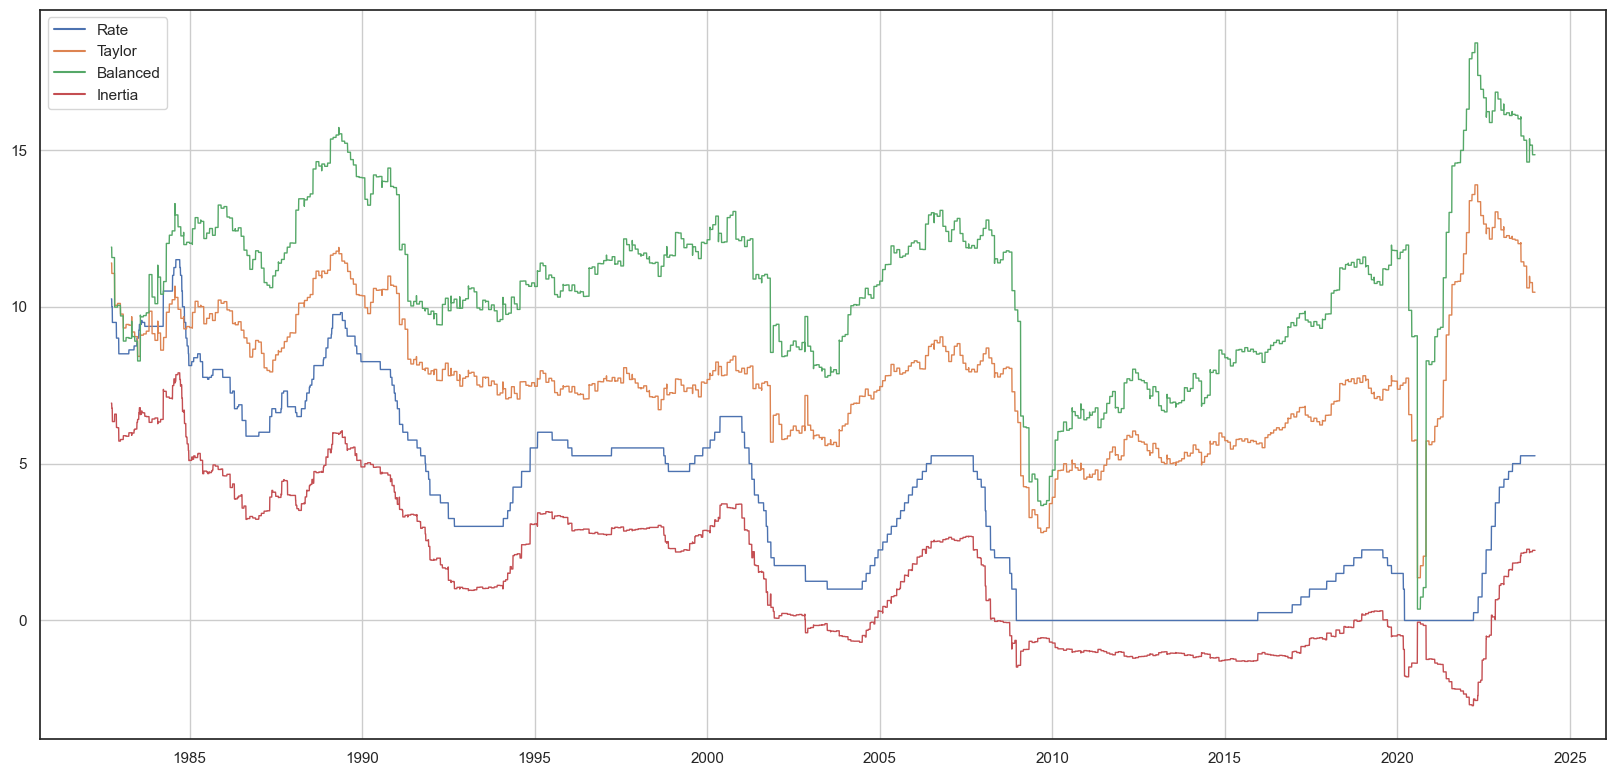

In [ ]:


fig, ax = plt.subplots()
ax = sns.lineplot(data=taylor, dashes=False, lw=1)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.grid(True)
plt.show()

In [ ]:
# Deviation from Rate, which may trigger the rate change
taylor['Taylor-Rate'] = taylor['Taylor'] - taylor['Rate']
taylor['Balanced-Rate'] = taylor['Balanced'] - taylor['Rate']
taylor['Inertia-Rate'] = taylor['Inertia'] - taylor['Rate']

taylor['Taylor_diff'] = taylor['Taylor'].diff(1)
taylor['Balanced_diff'] = taylor['Balanced'].diff(1)
taylor['Inertia_diff'] = taylor['Inertia'].diff(1)

taylor

,Rate,Taylor,Balanced,Inertia,Taylor-Rate,Balanced-Rate,Inertia-Rate,Taylor_diff,Balanced_diff,Inertia_diff
1982-09-27,10.25,11.394336,11.899878,6.927518,1.144336,1.649878,-3.322482,NaN,NaN,NaN
1982-09-28,10.25,11.394336,11.899878,6.927518,1.144336,1.649878,-3.322482,0.000000,0.000000,0.000000
1982-09-29,10.25,11.394336,11.899878,6.927518,1.144336,1.649878,-3.322482,0.000000,0.000000,0.000000
1982-09-30,10.25,11.394336,11.899878,6.927518,1.144336,1.649878,-3.322482,0.000000,0.000000,0.000000
1982-10-01,10.00,11.061999,11.567540,6.764869,1.061999,1.567540,-3.235131,-0.332337,-0.332337,-0.162649
...,...,...,...,...,...,...,...,...,...,...
2023-12-24,5.25,10.463508,14.845051,2.235742,5.213508,9.595051,-3.014258,0.000000,0.000000,0.000000
2023-12-25,5.25,10.463508,14.845051,2.235742,5.213508,9.595051,-3.014258,0.000000,0.000000,0.000000
2023-12-26,5.25,10.463508,14.845051,2.235742,5.213508,9.595051,-3.014258,0.000000,0.000000,0.000000
2023-12-27,5.25,10.463508,14.845051,2.235742,5.213508,9.595051,-3.014258,0.000000,0.000000,0.000000


In [ ]:
# AÑADIR VALORES AL DATAFRAME
def add_taylor(df, window=1):
    taylor_ma = taylor.rolling(window).mean()
    df['Taylor'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor'].values[0])
    df['Balanced'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced'].values[0])
    df['Inertia'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia'].values[0])
    df['Taylor-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Taylor-Rate'].values[0])
    df['Balanced-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Balanced-Rate'].values[0])
    df['Inertia-Rate'] = df.index.map(lambda x: taylor_ma.loc[taylor_ma.index == x + relativedelta(days=-1), 'Inertia-Rate'].values[0])
    df['Taylor_diff'] = df['Taylor'].diff(1)
    df['Balanced_diff'] = df['Balanced'].diff(1)
    df['Inertia_diff'] = df['Inertia'].diff(1)
    
    

In [ ]:
add_taylor(nontext_data)
add_taylor(nontext_ma2, 60)
add_taylor(nontext_ma3, 90)
add_taylor(nontext_ma6, 180)
add_taylor(nontext_ma12, 360)

In [ ]:
fomc_calendar.index.get_level_values(0).values

array(['1982-10-05T00:00:00.000000000', '1982-11-16T00:00:00.000000000',
       '1982-12-21T00:00:00.000000000', '1983-01-14T00:00:00.000000000',
       '1983-01-21T00:00:00.000000000', '1983-01-28T00:00:00.000000000',
       '1983-02-09T00:00:00.000000000', '1983-03-29T00:00:00.000000000',
       '1983-04-29T00:00:00.000000000', '1983-05-24T00:00:00.000000000',
       '1983-06-23T00:00:00.000000000', '1983-07-13T00:00:00.000000000',
       '1983-08-23T00:00:00.000000000', '1983-09-08T00:00:00.000000000',
       '1983-10-04T00:00:00.000000000', '1983-11-15T00:00:00.000000000',
       '1983-12-20T00:00:00.000000000', '1984-01-31T00:00:00.000000000',
       '1984-03-20T00:00:00.000000000', '1984-03-27T00:00:00.000000000',
       '1984-05-22T00:00:00.000000000', '1984-07-17T00:00:00.000000000',
       '1984-08-21T00:00:00.000000000', '1984-10-02T00:00:00.000000000',
       '1984-11-07T00:00:00.000000000', '1984-12-18T00:00:00.000000000',
       '1985-01-18T00:00:00.000000000', '1985-02-13

In [ ]:
fomc_calendar.loc['2020-06-10', 'Rate'] = 0
fomc_calendar.loc['2020-07-29', 'Rate'] = 0
fomc_calendar.loc['2020-06-10', 'RateDiff'] = 0
fomc_calendar.loc['2020-07-29', 'RateDiff'] = 0


## GUARDAR DATOS

In [ ]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
        
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)

In [ ]:
# Save data
save_data(nontext_data, 'nontext_data')
save_data(nontext_ma2, 'nontext_ma2')
save_data(nontext_ma3, 'nontext_ma3')
save_data(nontext_ma6, 'nontext_ma6')
save_data(nontext_ma12, 'nontext_ma12')
save_data(treasury_q, 'treasury')
save_data(fomc_calendar, 'fomc_calendar')